In [1]:
import sys
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

In [2]:
sys.path.append('../')

In [3]:
from pydil.optimal_transport import OptimalTransportSolver
from pydil.optimal_transport import EmpiricalBarycenterSolver
from pydil.optimal_transport import GaussianMixtureBarycenterSolver

from pydil.gmm_dictionary import DiagonalGaussianMixture
from pydil.gmm_dictionary import DiagonalLabeledGaussianMixture

from pydil.utils import visualize_gmm

2024-08-02 12:51:42.102870: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 12:51:42.104002: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 12:51:42.127563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 12:51:42.507664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Empirical Case

## Unsupervised Case

### Generating Synthetic Data

In [4]:
mu_1 = np.array([0., 0.])
mu_2 = np.array([4., 0.])
mu_3 = np.array([2., 2. * math.sqrt(3) / 2])

cov_1 = cov_2 = cov_3 = .05 * np.eye(2)

In [5]:
n_samples = 200

X1 = torch.from_numpy(
    np.random.multivariate_normal(mu_1, cov_1, size=n_samples)).float()

X2 = torch.from_numpy(
    np.random.multivariate_normal(mu_2, cov_2, size=n_samples)).float()

X3 = torch.from_numpy(
    np.random.multivariate_normal(mu_3, cov_3, size=n_samples)).float()

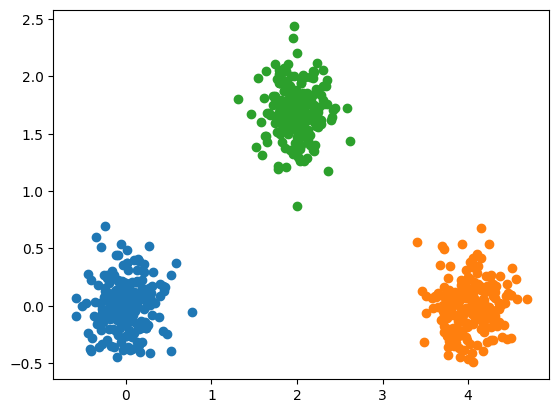

In [6]:
plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X3[:, 0], X3[:, 1])

### Empirical Barycenter through the EMD

In [7]:
emd_solver = OptimalTransportSolver()

In [8]:
barycenter_solver = EmpiricalBarycenterSolver(
    n_samples=n_samples,
    ot_solver=emd_solver,
    beta=None,
    n_iter_max=100,
    tol=1e-4,
    verbose=True,
    propagate_labels=False,
    penalize_labels=False,
    log=False,
    init='random'
)

In [9]:
XB = barycenter_solver([X1, X2, X3])

---------------------------------------------------------------------------------------------------------
|        Iteration        |          Loss           |          δLoss          |      Elapsed Time       |
---------------------------------------------------------------------------------------------------------
|            1            |    8.998433828353882    |           inf           |  0.012444734573364258   |
|            2            |   3.3348761796951294    |    5.663557648658752    |   0.00976872444152832   |
|            3            |   3.3347564935684204    | 0.00011968612670898438  |  0.009171247482299805   |
|            4            |    3.334750384092331    |  6.109476089477539e-06  |  0.009122610092163086   |
---------------------------------------------------------------------------------------------------------
Barycenter calculation took 0.04068112373352051 seconds


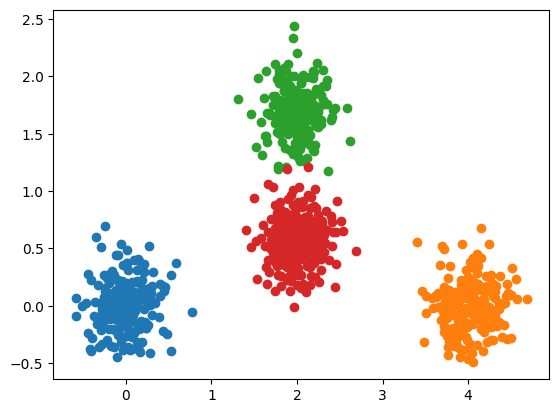

In [10]:
plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X3[:, 0], X3[:, 1])
plt.scatter(XB[:, 0], XB[:, 1])

## Supervised Case

### Regression

In [11]:
emd_solver = OptimalTransportSolver()
barycenter_solver = EmpiricalBarycenterSolver(
    n_samples=n_samples,
    ot_solver=emd_solver,
    beta=1.0,
    n_iter_max=100,
    tol=1e-4,
    verbose=True,
    propagate_labels=True,
    penalize_labels=False,
    log=False,
    init='samples'
)

In [12]:
mu_1 = np.array([0., 0.])
mu_2 = np.array([4., 0.])
mu_3 = np.array([2., 2. * math.sqrt(3) / 2])

cov_1 = cov_2 = cov_3 = .05 * np.eye(2)

Y1 = torch.cdist(X1, X1.mean(dim=0)[None, :], p=2)
Y2 = torch.cdist(X2, X2.mean(dim=0)[None, :], p=2)
Y3 = torch.cdist(X3, X3.mean(dim=0)[None, :], p=2)

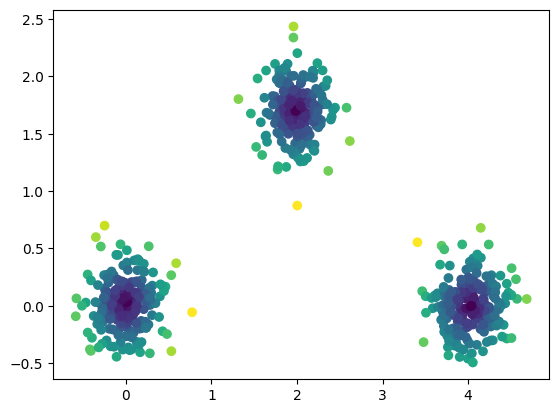

In [13]:
plt.scatter(X1[:, 0], X1[:, 1], c=Y1.squeeze())
plt.scatter(X2[:, 0], X2[:, 1], c=Y2.squeeze())
plt.scatter(X3[:, 0], X3[:, 1], c=Y3.squeeze())

In [14]:
XB, YB = barycenter_solver([X1, X2, X3], [Y1, Y2, Y3])

---------------------------------------------------------------------------------------------------------
|        Iteration        |          Loss           |          δLoss          |      Elapsed Time       |
---------------------------------------------------------------------------------------------------------
|            1            |    5.821723461151123    |           inf           |  0.009403467178344727   |
|            2            |    3.335068792104721    |    2.486654669046402    |  0.010346174240112305   |
|            3            |   3.3346602618694305    | 0.00040853023529052734  |   0.00970005989074707   |
|            4            |    3.334629774093628    | 3.0487775802612305e-05  |  0.010456323623657227   |
---------------------------------------------------------------------------------------------------------
Barycenter calculation took 0.040090322494506836 seconds


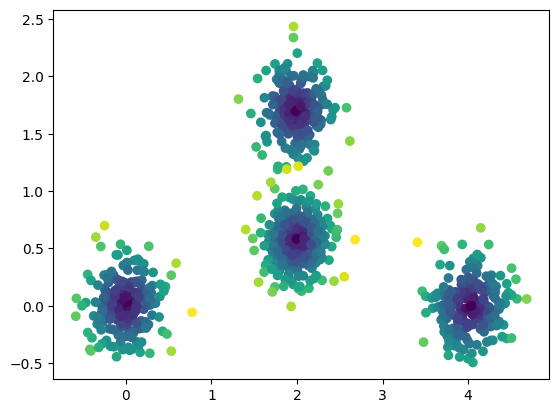

In [15]:
plt.scatter(X1[:, 0], X1[:, 1], c=Y1)
plt.scatter(X2[:, 0], X2[:, 1], c=Y2)
plt.scatter(X3[:, 0], X3[:, 1], c=Y3)
plt.scatter(XB[:, 0], XB[:, 1], c=YB)

### Classification

In [16]:
n_samples = 200

mu_1 = [np.array([0., 0.]), np.array([0.5, 1.0])]
cov_1 = [
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
]

mu_2 = [np.array([4.0, -0.5]), np.array([4.5, 1.0])]
cov_2 = [
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
]

mu_3 = [np.array([2.0, 3.0]), np.array([2.5, 4.0])]
cov_3 = [
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
]


X1 = torch.from_numpy(
    np.concatenate([np.random.multivariate_normal(mu_1[0], cov_1[0], size=n_samples // 2),
                    np.random.multivariate_normal(mu_1[1], cov_1[1], size=n_samples // 2)],
                   axis=0)).float()
Y1 = torch.from_numpy(np.concatenate([np.stack([np.array([1, 0])] * 100),
                                      np.stack([np.array([0, 1])] * 100)],
                                     axis=0),
).float()

X2 = torch.from_numpy(
    np.concatenate([np.random.multivariate_normal(mu_2[0], cov_2[0], size=n_samples // 2),
                    np.random.multivariate_normal(mu_2[1], cov_2[1], size=n_samples // 2)],
                   axis=0)).float()
Y2 = torch.from_numpy(np.concatenate([np.stack([np.array([1, 0])] * 100),
                                      np.stack([np.array([0, 1])] * 100)],
                                     axis=0),
).float()

X3 = torch.from_numpy(
    np.concatenate([np.random.multivariate_normal(mu_3[0], cov_3[0], size=n_samples // 2),
                    np.random.multivariate_normal(mu_3[1], cov_3[1], size=n_samples // 2)],
                   axis=0)).float()
Y3 = torch.from_numpy(np.concatenate([np.stack([np.array([1, 0])] * 100),
                                      np.stack([np.array([0, 1])] * 100)],
                                     axis=0),
).float()

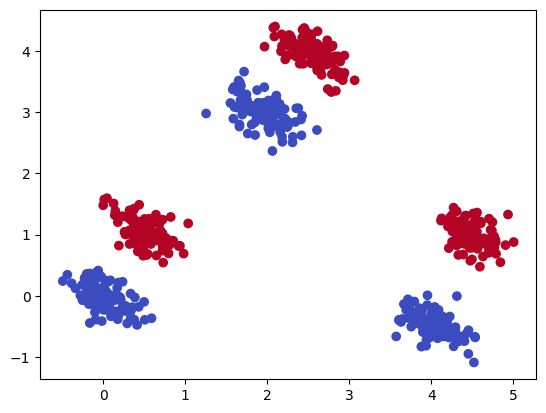

In [17]:
plt.scatter(X1[:, 0], X1[:, 1], c=Y1[:, 1], cmap=plt.cm.coolwarm)
plt.scatter(X2[:, 0], X2[:, 1], c=Y2[:, 1], cmap=plt.cm.coolwarm)
plt.scatter(X3[:, 0], X3[:, 1], c=Y3[:, 1], cmap=plt.cm.coolwarm)

In [18]:
emd_solver = OptimalTransportSolver()
barycenter_solver = EmpiricalBarycenterSolver(
    n_samples=n_samples,
    ot_solver=emd_solver,
    beta=1.0,
    n_iter_max=100,
    tol=1e-4,
    verbose=True,
    propagate_labels=True,
    penalize_labels=True,
    log=False,
    init='samples'
)

In [19]:
XB, YB = barycenter_solver([X1, X2, X3], [Y1, Y2, Y3])

---------------------------------------------------------------------------------------------------------
|        Iteration        |          Loss           |          δLoss          |      Elapsed Time       |
---------------------------------------------------------------------------------------------------------
|            1            |    8.491482734680176    |           inf           |  0.010643959045410156   |
|            2            |    4.834468245506287    |    3.657014489173889    |  0.009863138198852539   |
|            3            |    4.798289895057678    |   0.0361783504486084    |  0.009953975677490234   |
|            4            |    4.798234701156616    |  5.519390106201172e-05  |  0.009000062942504883   |
---------------------------------------------------------------------------------------------------------
Barycenter calculation took 0.03965950012207031 seconds


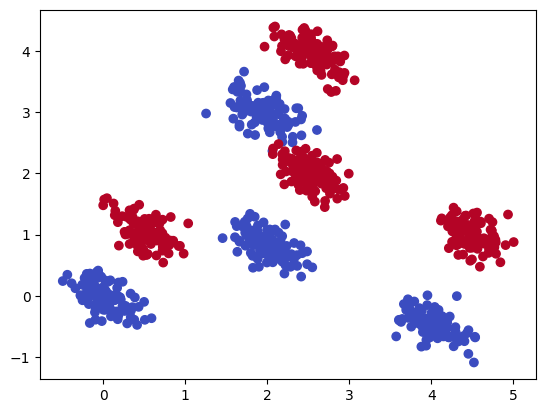

In [20]:
plt.scatter(X1[:, 0], X1[:, 1], c=Y1[:, 1], cmap=plt.cm.coolwarm)
plt.scatter(X2[:, 0], X2[:, 1], c=Y2[:, 1], cmap=plt.cm.coolwarm)
plt.scatter(X3[:, 0], X3[:, 1], c=Y3[:, 1], cmap=plt.cm.coolwarm)
plt.scatter(XB[:, 0], XB[:, 1], c=YB[:, 1], cmap=plt.cm.coolwarm)

# Gaussian Mixture Case

## Unsupervised Case

In [21]:
mu_1 = [np.array([0., 0.]), np.array([0.5, 0.5])]
mu_2 = [np.array([4.0, 0.5]), np.array([4.5, 1.0])]
mu_3 = [np.array([2.0, 4.0]), np.array([2.5, 4.0])]

cov_1 = [
    np.array([[0.05, -0.025],
              [-0.025, 0.05]]),
    np.array([[0.05, -0.025],
              [-0.025, 0.10]]),
]

cov_2 = [
    np.array([[0.05, 0.025],
              [0.025, 0.05]]),
    np.array([[0.1, 0.025],
              [0.025, 0.05]]),
]

cov_3 = [
    np.array([[0.1, -0.025],
              [-0.025, 0.1]]),
    np.array([[0.05, -0.025],
              [-0.025, 0.045]]),
]

In [22]:
X1 = torch.from_numpy(
    np.concatenate([np.random.multivariate_normal(mu_1[0], cov_1[0], size=n_samples // 2),
                    np.random.multivariate_normal(mu_1[1], cov_1[1], size=n_samples // 2)],
                   axis=0)).float()
X2 = torch.from_numpy(
    np.concatenate([np.random.multivariate_normal(mu_2[0], cov_2[0], size=n_samples // 2),
                    np.random.multivariate_normal(mu_2[1], cov_2[1], size=n_samples // 2)],
                   axis=0)).float()
X3 = torch.from_numpy(
    np.concatenate([np.random.multivariate_normal(mu_3[0], cov_3[0], size=n_samples // 2),
                    np.random.multivariate_normal(mu_3[1], cov_3[1], size=n_samples // 2)],
                   axis=0)).float()

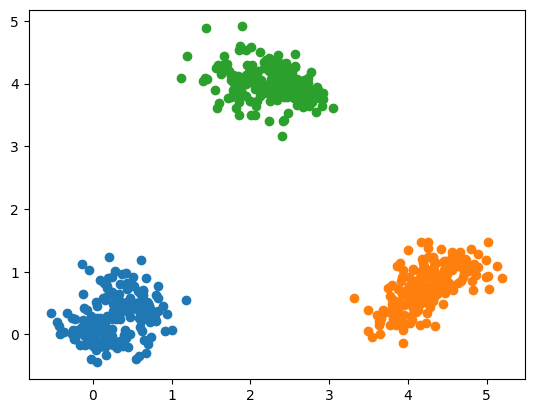

In [23]:
plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X3[:, 0], X3[:, 1])

In [24]:
gmm1 = DiagonalGaussianMixture(
    n_components=3
).fit(X1)

gmm2 = DiagonalGaussianMixture(
    n_components=3
).fit(X2)

gmm3 = DiagonalGaussianMixture(
    n_components=3
).fit(X3)

<AxesSubplot: >

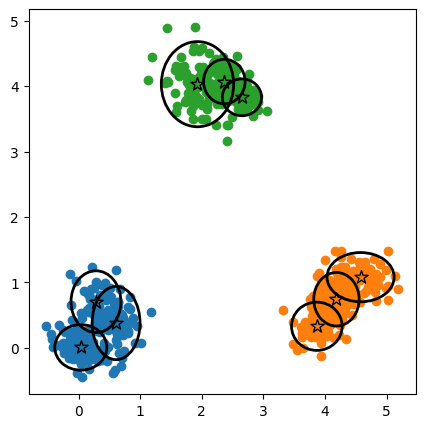

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X1[:, 0], X1[:, 1])
ax.scatter(X2[:, 0], X2[:, 1])
ax.scatter(X3[:, 0], X3[:, 1])


visualize_gmm(gmm1.means, torch.stack([torch.diag(C) for C in gmm1.variances]), ax=ax,
              kwargs_scatter={'c': 'tab:blue',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})
visualize_gmm(gmm2.means, torch.stack([torch.diag(C) for C in gmm2.variances]), ax=ax,
              kwargs_scatter={'c': 'tab:orange',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})
visualize_gmm(gmm3.means, torch.stack([torch.diag(C) for C in gmm3.variances]), ax=ax,
              kwargs_scatter={'c': 'tab:green',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})

In [30]:
barycenter_solver = EmpiricalBarycenterSolver(
    n_samples=n_samples,
    ot_solver=emd_solver,
    beta=None,
    n_iter_max=100,
    tol=1e-4,
    verbose=True,
    propagate_labels=False,
    penalize_labels=False,
    log=False,
    init='random'
)
XB = barycenter_solver([X1, X2, X3])

---------------------------------------------------------------------------------------------------------
|        Iteration        |          Loss           |          δLoss          |      Elapsed Time       |
---------------------------------------------------------------------------------------------------------
|            1            |   14.170862525701523    |           inf           |  0.014887809753417969   |
|            2            |    5.422670483589172    |    8.74819204211235     |   0.01365518569946289   |
|            3            |    5.422065377235413    |  0.0006051063537597656  |  0.013176441192626953   |
|            4            |    5.421996235847473    |  6.914138793945312e-05  |  0.013416528701782227   |
---------------------------------------------------------------------------------------------------------
Barycenter calculation took 0.055426597595214844 seconds


In [26]:
gmm_barycenter_solver = GaussianMixtureBarycenterSolver(
    ot_solver=emd_solver, verbose=True
)

In [27]:
means_barycenter, variances_barycenter = gmm_barycenter_solver(
    [gmm1.means, gmm2.means, gmm3.means],
    [gmm1.variances, gmm2.variances, gmm3.variances],
)

---------------------------------------------------------------------------------------------------------
|        Iteration        |          Loss           |          δLoss          |      Elapsed Time       |
---------------------------------------------------------------------------------------------------------
|            1            |   14.849970579147339    |           inf           |  0.0015783309936523438  |
|            2            |    5.259921073913574    |    9.590049505233765    |  0.0005223751068115234  |
|            3            |    5.259921073913574    |           0.0           |  0.0003523826599121094  |
---------------------------------------------------------------------------------------------------------
Barycenter calculation took 0.0026841163635253906 seconds


<AxesSubplot: >

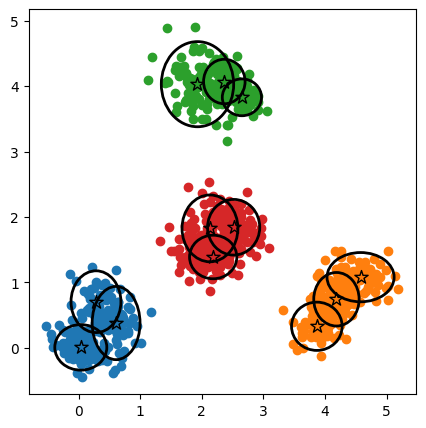

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X1[:, 0], X1[:, 1])
ax.scatter(X2[:, 0], X2[:, 1])
ax.scatter(X3[:, 0], X3[:, 1])
ax.scatter(XB[:, 0], XB[:, 1])


visualize_gmm(gmm1.means, torch.stack([torch.diag(C) for C in gmm1.variances]), ax=ax,
              kwargs_scatter={'c': 'tab:blue',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})
visualize_gmm(gmm2.means, torch.stack([torch.diag(C) for C in gmm2.variances]), ax=ax,
              kwargs_scatter={'c': 'tab:orange',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})
visualize_gmm(gmm3.means, torch.stack([torch.diag(C) for C in gmm3.variances]), ax=ax,
              kwargs_scatter={'c': 'tab:green',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})
visualize_gmm(means_barycenter, torch.stack([torch.diag(C) for C in variances_barycenter]), ax=ax,
              kwargs_scatter={'c': 'tab:red',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k'},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2})